# Projeto Final de EA999

Aluno: Otávio Leite Bastos

Prof. Lotufo

## Referências

https://www.kaggle.com/moltean/fruits/data


## Imports

In [ ]:
import numpy as np
import torchvision
import torch
from torch import nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

## Extração dos Dados

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Loading data
transforms_train = T.Compose([                              
                              T.Resize((224,224)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])

In [ ]:
root = 'fruits-360_dataset/fruits-360/'

In [ ]:
!unzip -q -n "/gdrive/Shared drives/Drive compartilhado EA999/fruits.zip"

## Carregando Dados

In [ ]:
image_data_train = ImageFolder(root + 'Training/', transform=transforms_train)
image_data_test = ImageFolder(root + 'Test/', transform=transforms_train)

In [ ]:
train_loader = DataLoader(dataset=image_data_train,
                          batch_size=200,
                          shuffle=False)

test_loader = DataLoader(dataset=image_data_test,
                         batch_size=200,
                         shuffle=False)

## Fine-tuning

### Definição Novo Modelo

In [ ]:
class MyClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(in_features=512, out_features=100)
        self.fc1 = nn.Linear(in_features=100, out_features=120)

    def forward(self, x):        
        x = self.fc0(x)       
        x = F.relu(x)
        x = self.fc1(x) 
        
        return x.view(-1, 120)

In [ ]:
linear_model = MyClassifier()
linear_model.load_state_dict(torch.load("/gdrive/My Drive/Colab Notebooks/Projeto Final EA999/model_state_dict.pth"))

linear_model.eval()

MyClassifier(
  (fc0): Linear(in_features=512, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=120, bias=True)
)

### Baixando Resnet34

In [ ]:
from torchvision.models.resnet import model_urls
model_urls['resnet34'] = model_urls['resnet34'].replace('https://', 'http://')

model_resnet = torchvision.models.resnet34(pretrained = True)

### Modelo Fine-tuning

In [ ]:
model_resnet.fc = linear_model

In [ ]:
for p in model_resnet.parameters():
  p.requires_grad = False

In [ ]:
for p in model_resnet.layer4.parameters():
    p.requires_grad = True

In [ ]:
model_ft = model_resnet

del model_resnet

model_ft = model_ft.to(device)

model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Definição do Otimizador e da Função de Custo

In [ ]:
# learning rate reduzido em 100x em relação à parte 2.
optimizer = torch.optim.Adam(model_ft.layer4.parameters(),lr=0.000001)

loss_function = torch.nn.CrossEntropyLoss()

### Treinamento

In [ ]:
loss_his = []

EPOCH = 30

best_loss = 10

for epoch in range(EPOCH):
  for (images,labels) in tqdm(train_loader):
    
    optimizer.zero_grad()
    outputs = model_ft(images.cuda())
    loss = loss_function(outputs.cuda(), labels.cuda())
    loss.backward()
    optimizer.step()

    loss_his.append(loss)

    if loss < best_loss:
      best_loss = loss
      torch.save(model_ft.state_dict(), 'saved_model')

    # n_acertos = 0
    # total = 0

    # validação
    # for (images,labels) in tqdm(test_loader):
      
    #   output = model_ft(images.cuda())
    #   _, predicted = torch.max(output,1)
    #   n_acertos += (predicted == labels.cuda()).sum()
    #   total += labels.size(0)

  print('Epoch [%d], Loss: %.7f' % (epoch+1, loss.item()) )

  # print('Acurácia do modelo: %.3f %%' %((100*n_acertos)/(total)))

  print('Menor perda: %.7f ' % best_loss.item())


Epoch [1], Loss: 0.0000140
Menor perda: 0.0000140 



Epoch [2], Loss: 0.0000083
Menor perda: 0.0000083 



Epoch [3], Loss: 0.0000046
Menor perda: 0.0000046 



Epoch [4], Loss: 0.0000027
Menor perda: 0.0000027 



Epoch [5], Loss: 0.0000017
Menor perda: 0.0000017 



Epoch [6], Loss: 0.0000012
Menor perda: 0.0000010 



Epoch [7], Loss: 0.0000008
Menor perda: 0.0000006 



Epoch [8], Loss: 0.0000005
Menor perda: 0.0000004 



Epoch [9], Loss: 0.0000004
Menor perda: 0.0000003 



Epoch [10], Loss: 0.0000003
Menor perda: 0.0000002 



Epoch [11], Loss: 0.0000002
Menor perda: 0.0000001 



Epoch [12], Loss: 0.0000001
Menor perda: 0.0000001 



Epoch [13], Loss: 0.0000001
Menor perda: 0.0000001 



Epoch [14], Loss: 0.0000001
Menor perda: 0.0000000 



Epoch [15], Loss: 0.0000001
Menor perda: 0.0000000 



Epoch [16], Loss: 0.0000001
Menor perda: 0.0000000 



Epoch [17], Loss: 0.0000000
Menor perda: 0.0000000 


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=224x224 at 0x7FFA2A30E080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 629, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


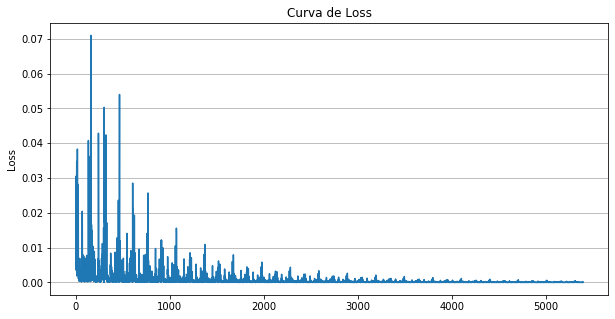

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('Curva de Loss')
plt.ylabel('Loss')
ax = plt.axes()        
ax.yaxis.grid() # horizontal lines
plt.plot(loss_his)
plt.show()

### Acurácia Final do Modelo de Perda Mínima

In [ ]:
model_ft.load_state_dict(torch.load('saved_model'))

<All keys matched successfully>

In [ ]:
n_acertos = 0
total = 0

list_labels = torch.tensor([], dtype=torch.int64).to(device)
list_predicted = torch.tensor([], dtype=torch.int64).to(device)

for (images,labels) in tqdm(test_loader, leave=False):
  
  output = model_ft(images.cuda())
  _, predicted = torch.max(output,1)
  n_acertos += (predicted == labels.cuda()).sum()
  total += labels.size(0)

  list_labels = torch.cat((list_labels, labels.cuda()))
  list_predicted = torch.cat((list_predicted, predicted))

print('Acurácia do modelo de perda mínima: %.3f %%' %((100*n_acertos)/(total)))

print('Menor perda: %.5f ' % best_loss)

Acurácia do modelo de perda mínima: 99.000 %
Menor perda: 0.00000 


### Matriz de Confusão, Precision Score e Recall Score

In [ ]:
list_labels

tensor([  0,   0,   0,  ..., 119, 119, 119], device='cuda:0')

In [ ]:
list_predicted

tensor([  0,   0,   0,  ..., 119, 119, 119], device='cuda:0')

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

cm_ft = confusion_matrix(list_labels.cpu(), list_predicted.cpu())

ps_ft = precision_score(y_true=list_labels.cpu(), y_pred=list_predicted.cpu(), average='weighted')

rs_ft = recall_score(y_true=list_labels.cpu(), y_pred=list_predicted.cpu(), average='weighted')

f1_score_ft = f1_score(y_true=list_labels.cpu(), y_pred=list_predicted.cpu(), average='weighted')

print(cm_ft)

print('\n Precision Score FT: %.3f %%' % (ps_ft*100))

print(' Recall Score FT: %.3f %%' % (rs_ft*100))

print(' F1 Score FT: %.3f %%' % (f1_score_ft*100))


[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 163 ...   0   0   0]
 ...
 [  0   0   0 ... 127   0   0]
 [  0   0   0 ...   0 153   0]
 [  0   0   0 ...   0   0 249]]

 Precision Score FT: 99.301 %
 Recall Score FT: 99.234 %
 F1 Score FT: 99.224 %


In [ ]:
def plt_confusion_matrix(confusion_matrix):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111) 
    cax = ax.matshow(confusion_matrix, cmap='plasma') 
    plt.title('Confusion matrix') 
    fig.colorbar(cax) 
    plt.xlabel('Predicted') 
    plt.ylabel('Labels') 
    plt.show()

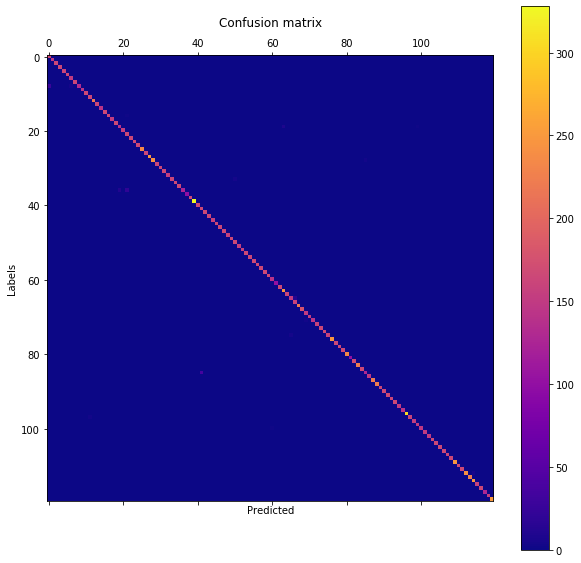

In [ ]:
plt_confusion_matrix(cm_ft)

In [ ]:
cm_zero_diag = cm_ft - cm_ft*np.identity(len(cm_ft))

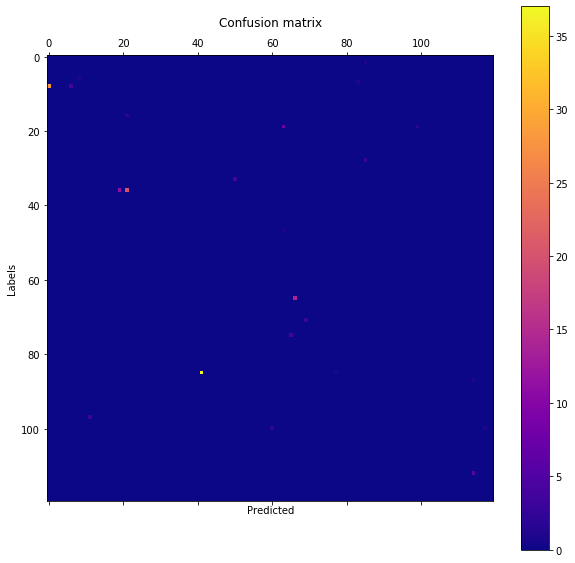

In [ ]:
plt_confusion_matrix(cm_zero_diag)

In [ ]:
print('F1 Score FT: %.3f %%' % (f1_score_ft*100))

F1 Score FT: 99.224 %


### Resultados

2 Camadas Lineares finais destravadas com learning rate de 0,0001 e 10 epocas => F1 Score: 96.821 %

1 Camada Linear final destravada com learning rate de 0,0005 e 30 epocas => F1 Score: 85.368 %

2 Camadas da Layer 4 destravadas com learning rate de 0,000001 e 16 epocas => F1 Score: 99.224 %
